In [1]:
import mip
import itertools
import random
import pandas as pd

from scipy.spatial import distance_matrix
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class VRPInstance(object):
    def __init__(self, nodes=None, nodes_pos = {}, trucks = None, origin = {}, cost_matrix = None,
                blocked_nodes = {}): # TODO add miga_and_bloqued
        """ create an empty instance
        """
        if nodes == None:
            nodes = []
        if trucks == None:
            trucks = []
            
        self.trucks = trucks
        self.origin = origin
        self.cost_matrix =  cost_matrix # this could be part of the edges attributes of self.graph
        self.blocked_nodes = blocked_nodes
        
        # graph 
        G = nx.Graph() 
        G.add_nodes_from(nodes)
        for node_id,pos in nodes_pos.items():
            G.nodes[node_id]['pos'] = (pos[0],pos[1])

        self.graph = G

    @classmethod 
    def generate_random_xy_instance(cls, n_nodes = 15, n_trucks=2, starting_nodes='default', blocked_nodes = None):
        """[summary]

        Args:
            n_nodes (int, optional): [description]. Defaults to 15.
            n_trucks (int, optional): [description]. Defaults to 2.
            starting_nodes (str, optional): [description]. Defaults to 'default'.

        Returns:
            [type]: [description]
        """        
        # set seed 
        random.seed(31415)             
        nodes = list(range(n_nodes))  
        nodes_pos = {}
        nodes_pos_list  = []
        for node_id in nodes:
            x = random.uniform(0, 200)
            y = random.uniform(0, 200)
            nodes_pos[node_id] = (x,y) 
            nodes_pos_list.append([x,y])
            
        cost_matrix = distance_matrix(nodes_pos_list, nodes_pos_list)
        
        nodes = list(range(cost_matrix.shape[0]))
        trucks = list(range(n_trucks))
        if starting_nodes == 'default':
            origin = {}
            for k in trucks:
                origin[k]=k
        elif type(starting_nodes) == dict:
            origin = deepcopy(starting_nodes)
            
        return cls(nodes = nodes, 
                   nodes_pos = nodes_pos, 
                   trucks = trucks,
                   origin = origin,
                   cost_matrix=cost_matrix,
                   blocked_nodes=blocked_nodes)
    @property
    def nodes(self):
        return list(self.graph.nodes)
    
    def cost(self, i,j,k):
        if j != self.origin[k]:
            return self.cost_matrix[i][j]
        else:
            return 0 # no cost for return to origin 


    @classmethod
    def generate_random_distance_instance(cls, n_nodes, n_trucks):
        # TODO
        raise NotImplementedError('builder not yet implemented')
        #cost_matrix  = np.random.rand(45,45) # matriz tiempo o distancia
        #cost_matrix =  cost_matrix + cost_matrix.T  - 2*np.diag(cost_matrix.diagonal())
    
    def plot_instance(self):
        G = self.graph
        pos=nx.get_node_attributes(G,'pos')
        nx.draw(G, pos=pos, with_labels = True)
    
    def plot_solution(self, x, y, file_name='graph.png'):
        """ 
        plot the solution 

        Args:
            x ([dict]): dict with solution {x[(i,j,k)] : mip.Var, ... }
        """         
        
        G = deepcopy(self.graph)
        G.add_edges_from([(key[0], key[1]) for key in x.keys() if x[key].x == 1 and key[1] not in list(vrp_instance.origin.values())]) 
        pos = nx.get_node_attributes(G,'pos')
        diccionario_camiones = dict([key for key in y.keys() if y[key].x==1])
        node_color = self.nodes
        for key in diccionario_camiones.keys():
            node_color[key] = diccionario_camiones[key]
        
        max_color = np.max(node_color) + 1
        labels = {nodo:nodo for nodo in self.nodes}
        origen = self.origin
        for k in origen.keys():
            labels[origen[k]] = str(labels[origen[k]])+'*'
        # save plot
        if len(node_color) != len(pos):
            node_color = []
        f = plt.figure()
        nx.draw(G, pos=pos, labels=labels,
                node_color = node_color, cmap=plt.cm.spring,
                with_labels = True, ax=f.add_subplot(111))
        
        """
        for key,var in x.items():
            print('x',key, var.x)
    
        for key,var in y.items():
            print('y',key, var.x)
        """
        values = {}
        for k in self.trucks:
            df_x = [key for key in x.keys() if x[key].x == 1]
            df_x = pd.DataFrame(df_x, columns=['i','j','k'])
            df_x = df_x.query(f'k=={k}')
            if df_x.shape[0] > 0:
                values[k] = [df_x.iloc[0][['i','j']].values[0]]
                index = values[k][-1]
                counter = 0
                while counter < df_x.shape[0]-1:
                    values[k] += [df_x.query(f'j=={index}')['i'].values[0]]
                    index = values[k][-1]
                    counter += 1

        for k in values.keys():
            print('total nodes served by {0} = {1}'.format(k, len(values[k])))
        for k in values.keys():
            print('node_list = {}'.format(values[k]))

In [3]:
def find_optimal_solution(vrp_instance, objective_function = 'min_distance'):
    nodes = vrp_instance.nodes
    trucks = vrp_instance.trucks
    origin = vrp_instance.origin
    blocked_nodes = vrp_instance.blocked_nodes
    
    # model
    model = mip.Model(name =  'vrp')
    # ========================== #
    # ==== var declaration ===== #
    # ========================== #

    x = {}
    for i,j,k in itertools.product(nodes,nodes,trucks):
        # declarate path variables 
        if i != j : 
            x[(i,j,k)] = model.add_var(var_type = mip.BINARY , 
                                    name = f'path_{i}_{j}_{k}')

    y = {}    
    for i,k in itertools.product(nodes,trucks):
        # declarate path variables 
        y[(i,k)] = model.add_var(var_type = mip.CONTINUOUS , 
                                name = f'asignation_{i}_{k}')

    u = {} # path length variable 
    for i,k in itertools.product(nodes,trucks):
        u[(i,k)] = model.add_var(var_type = mip.INTEGER , 
                                name = f'order_{i}_{k}')

    # ======================== #
    # ===== constraints ====== #
    # ======================== #
    
        
    # 0. flow emerging from origin
    for k in trucks:
        model.add_constr(mip.xsum([x[(origin[k],j,k)] for j in nodes if j!= origin[k]]) <= 1, name=f'origin_out_cod_{k}' ) 

    # 1. flow conservation
    for i,k in itertools.product(nodes,trucks):
        if i != origin[k]:            
            model.add_constr(mip.xsum([x[(j,i,k)] for j in nodes if j!=i ]) == # lo que entra
                            mip.xsum([x[(i,j,k)] for j in nodes if j!=i ]) , # lo que sale
                            name = f'flow_conservation_{i}_{k}' )           
        
    # 2. y codification 
    for i,k in itertools.product(nodes,trucks):
        #model.add_constr(y[(i,k)] == mip.xsum([x[(i,j,k)] for j in nodes if j!=i]) , name=f'y[{i}{k}]_cod') 
        model.add_constr(y[(i,k)] == mip.xsum([x[(j,i,k)] for j in nodes if j!=i]) , name=f'y[{i}{k}]_cod')  
    
    # 3. demand fulfillment
    for i in nodes:
        if i not in origin.values(): # is not an origin node
            model.add_constr(mip.xsum([ y[(i,k)] for k in trucks]) == 1 , name=f'y[{i}{k}]_cod') 
    
    # 4. subtour elimination 
    graph_len = len(nodes)
    for k in trucks:
        for i,j in itertools.product(nodes,nodes):
            if i != j and (i != origin[k] and j!= origin[k]): # remove origin 
                model.add_constr(u[(i,k)] - u[(j,k)] + 1  <= graph_len*(1- x[(i,j,k)]) , name=f'subtour_constraint_{i}_{j}_{k}')
        
        model.add_constr(u[(origin[k],k)] == 1 , name=f'subtour_constraint_origin_{k}')
        
        for i in nodes:
            if i != origin[k] :
                model.add_constr(u[(i,k)] >=2  , name=f'subtour_constraint_lowerbound_{i}')
                model.add_constr(u[(i,k)] <= graph_len -1, name=f'subtour_constraint_upperbound_{i}')
                
    # 5. blocked nodes
    if blocked_nodes != None:
        for k in blocked_nodes.keys():
            for i in blocked_nodes[k]:
                model.add_constr(y[(i,k)] == 0, name=f'blocked_node_{k}_{i}')
    
    # ============================ #
    # ==== model declaration ===== #
    # ============================ #

    # objective function
    if objective_function == 'min_distance':
        model.objective = mip.xsum([x[key]*vrp_instance.cost(key[0],key[1], key[2]) for key in x.keys()])

    elif objective_function == 'lowest_pos':
        model.objective = mip.xsum([u[key] for key in u.keys()])
    
    if objective_function == 'min_dist_max_len':
        for key in u.keys():
            model.add_constr(u[key] <= int(graph_len/len(trucks) *1.15) +1  , name='max_len')
        model.objective = mip.xsum([x[key]*vrp_instance.cost(key[0],key[1], key[2]) for key in x.keys()])
    
    model.sens = mip.MINIMIZE

    # model tunning
    # cuts
    # -1  automatic, 0 disables completely, 
    # 1 (default) generates cutting planes in a moderate way,
    # 2 generates cutting planes aggressively  
    # 3 generates even more cutting planes
    model.cuts = 2 
    model.max_mip_gap = 0.005 # 0.5%
    model.max_seconds = 15*60 
    model.optimize()
        
    return x, y, u, model

total nodes served by 0 = 7
total nodes served by 1 = 10
node_list = [0, 14, 16, 15, 12, 5, 2]
node_list = [1, 7, 13, 10, 6, 3, 9, 4, 8, 11]
CPU times: user 6.65 s, sys: 1.46 s, total: 8.11 s
Wall time: 7.01 s


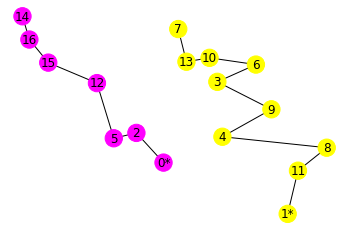

In [4]:
%%time
# generate a instance 
n_trucks = 2
n_nodes = 15
vrp_instance = VRPInstance.generate_random_xy_instance(n_nodes = n_nodes+n_trucks, 
                                                       n_trucks= n_trucks, 
                                                       starting_nodes='default')

x, y, u, model  = find_optimal_solution(vrp_instance, objective_function='min_distance')
vrp_instance.plot_solution(x, y, file_name = 'min_distance.png')


total nodes served by 0 = 9
total nodes served by 1 = 8
node_list = [0, 7, 13, 10, 6, 3, 9, 8, 11]
node_list = [1, 14, 16, 15, 12, 5, 2, 4]
CPU times: user 17 s, sys: 1.53 s, total: 18.5 s
Wall time: 17.7 s


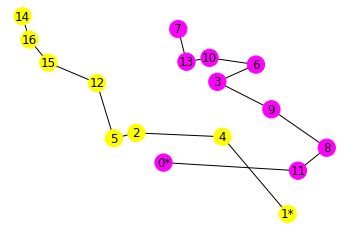

In [5]:
%%time
# generate a instance 
n_trucks = 2
n_nodes = 15
pedidos_bloqueados = {0:[2,5], 1:[11]}
vrp_instance = VRPInstance.generate_random_xy_instance(n_nodes = n_nodes+n_trucks, 
                                                       n_trucks= n_trucks, 
                                                       starting_nodes='default',
                                                      blocked_nodes=pedidos_bloqueados)

x, y, u, model  = find_optimal_solution(vrp_instance, objective_function='min_distance')
vrp_instance.plot_solution(x, y, file_name = 'min_distance.png')


total nodes served by 0 = 3
total nodes served by 1 = 3
total nodes served by 2 = 8
total nodes served by 3 = 5
node_list = [0, 9, 4]
node_list = [1, 8, 11]
node_list = [2, 14, 17, 16, 15, 12, 18, 5]
node_list = [3, 7, 13, 10, 6]
CPU times: user 11.3 s, sys: 667 ms, total: 11.9 s
Wall time: 11.9 s


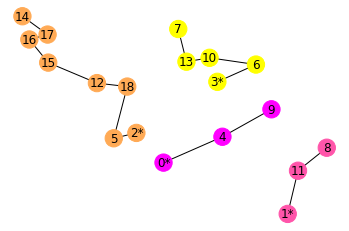

In [6]:
%%time
# generate a instance 
n_trucks = 4
n_nodes = 15
vrp_instance = VRPInstance.generate_random_xy_instance(n_nodes = n_nodes+n_trucks, 
                                                       n_trucks= n_trucks, 
                                                       starting_nodes='default')

x, y, u, model  = find_optimal_solution(vrp_instance, objective_function='min_distance')
vrp_instance.plot_solution(x, y, file_name = 'min_distance.png')


total nodes served by 1 = 3
total nodes served by 3 = 9
total nodes served by 4 = 2
node_list = [1, 8, 11]
node_list = [3, 14, 17, 16, 15, 12, 18, 13, 10]
node_list = [4, 9]
CPU times: user 8.53 s, sys: 1.02 s, total: 9.55 s
Wall time: 9.48 s


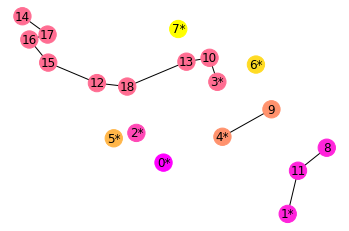

In [7]:
%%time
# generate a instance 
n_trucks = 4
n_nodes = 15
vrp_instance = VRPInstance.generate_random_xy_instance(n_nodes = n_nodes+n_trucks, 
                                                       n_trucks= 8, 
                                                       starting_nodes='default')

x, y, u, model  = find_optimal_solution(vrp_instance, objective_function='min_distance')
vrp_instance.plot_solution(x, y, file_name = 'min_distance.png')


In [ ]:
%%time
# generate a instance 
n_trucks = 
n_nodes = 15
vrp_instance = VRPInstance.generate_random_xy_instance(n_nodes = n_nodes+n_trucks, 
                                                       n_trucks= n_trucks, 
                                                       starting_nodes='default')

x, y, u, model  = find_optimal_solution(vrp_instance, objective_function='min_distance')
vrp_instance.plot_solution(x, y, file_name = 'min_distance.png')


total nodes served by 3 = 3
total nodes served by 4 = 2
total nodes served by 5 = 15
total nodes served by 6 = 5
total nodes served by 7 = 3
total nodes served by 8 = 2
total nodes served by 9 = 2
node_list = [3, 23, 27]
node_list = [4, 34]
node_list = [5, 19, 25, 22, 20, 30, 29, 16, 14, 17, 26, 15, 12, 18, 24]
node_list = [6, 21, 33, 13, 10]
node_list = [7, 31, 28]
node_list = [8, 11]
node_list = [9, 32]


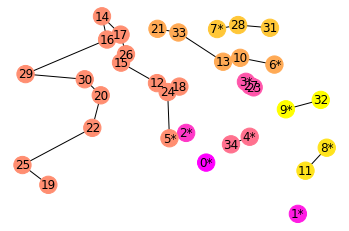

In [21]:
vrp_instance = VRPInstance.generate_random_xy_instance(n_nodes = 35, 
                                                       n_trucks=10, 
                                                       starting_nodes='default')

x, y, u, model  = find_optimal_solution(vrp_instance, objective_function='min_distance')
vrp_instance.plot_solution(x, y, file_name = 'min_distance.png')

# Sensibilidad a función objetivo 

total nodes served by 1 = 3
total nodes served by 3 = 9
total nodes served by 4 = 2
node_list = [1, 8, 11]
node_list = [3, 14, 17, 16, 15, 12, 18, 13, 10]
node_list = [4, 9]
CPU times: user 8.11 s, sys: 2.05 s, total: 10.2 s
Wall time: 9.98 s


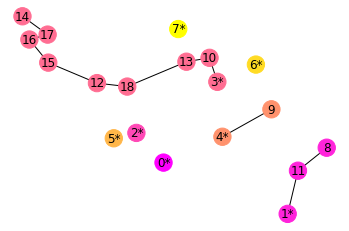

In [22]:
%%time
# generate a instance 
n_trucks = 4
n_nodes = 15
vrp_instance = VRPInstance.generate_random_xy_instance(n_nodes = n_nodes+n_trucks, 
                                                       n_trucks= 8, 
                                                       starting_nodes='default')

x, y, u, model  = find_optimal_solution(vrp_instance, objective_function='min_distance')
vrp_instance.plot_solution(x, y, file_name = 'min_distance.png')


total nodes served by 0 = 2
total nodes served by 1 = 3
total nodes served by 2 = 2
total nodes served by 3 = 3
total nodes served by 4 = 2
total nodes served by 5 = 3
total nodes served by 6 = 2
total nodes served by 7 = 2
node_list = [0, 16]
node_list = [1, 8, 13]
node_list = [2, 17]
node_list = [3, 12, 14]
node_list = [4, 11]
node_list = [5, 18, 10]
node_list = [6, 15]
node_list = [7, 9]
CPU times: user 14min 50s, sys: 13.2 s, total: 15min 3s
Wall time: 15min 3s


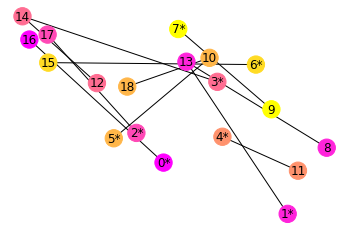

In [23]:
%%time
# generate a instance 
n_trucks = 4
n_nodes = 15
vrp_instance = VRPInstance.generate_random_xy_instance(n_nodes = n_nodes+n_trucks, 
                                                       n_trucks= 8, 
                                                       starting_nodes='default')

x, y, u, model  = find_optimal_solution(vrp_instance, objective_function='lowest_pos')
vrp_instance.plot_solution(x, y, file_name = 'lowest_pos.png')


total nodes served by 1 = 3
total nodes served by 3 = 3
total nodes served by 4 = 2
total nodes served by 5 = 3
total nodes served by 6 = 3
total nodes served by 7 = 3
node_list = [1, 8, 11]
node_list = [3, 12, 18]
node_list = [4, 9]
node_list = [5, 16, 15]
node_list = [6, 13, 10]
node_list = [7, 14, 17]
CPU times: user 1min 44s, sys: 2.68 s, total: 1min 46s
Wall time: 1min 46s


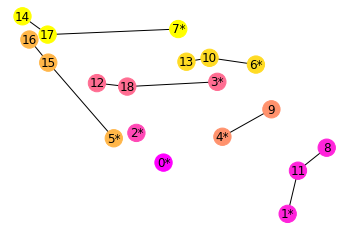

In [24]:
%%time
# generate a instance 
n_trucks = 4
n_nodes = 15
vrp_instance = VRPInstance.generate_random_xy_instance(n_nodes = n_nodes+n_trucks, 
                                                       n_trucks= 8, 
                                                       starting_nodes='default')

x, y, u, model  = find_optimal_solution(vrp_instance, objective_function='min_dist_max_len')
vrp_instance.plot_solution(x, y, file_name = 'min_dist_max_len.png')


# sandbox


In [2]:
class VRPInstance(object):
    def __init__(self, nodes=[], nodes_pos = {}, trucks = [],origin = {}, cost_matrix =  None ): # TODO add miga_and_bloqued
        """ create an empty instance
        """
        self.trucks = trucks
        self.origin = origin
        self.cost_matrix =  cost_matrix # this could be part of the edges attributes of self.graph

        # graph 
        G = nx.Graph() 
        G.add_nodes_from(nodes)
        for node_id,pos in nodes_pos.items():
            G.nodes[node_id]['pos'] = (pos[0],pos[1])

        self.graph = G

    @classmethod 
    def generate_random_xy_instance(cls, n_nodes = 15, n_trucks=2, starting_nodes='default'):
        """[summary]

        Args:
            n_nodes (int, optional): [description]. Defaults to 15.
            n_trucks (int, optional): [description]. Defaults to 2.
            starting_nodes (str, optional): [description]. Defaults to 'default'.

        Returns:
            [type]: [description]
        """        
        # set seed 
        random.seed(0)             
        nodes = list(range(n_nodes))  
        nodes_pos = {}
        nodes_pos_list  = []
        for node_id in nodes:
            x = random.uniform(0, 150)
            y = random.uniform(0, 150)
            nodes_pos[node_id] = (x,y) 
            nodes_pos_list.append([x,y])
            
        cost_matrix = distance_matrix(nodes_pos_list, nodes_pos_list)
        
        nodes = list(range(cost_matrix.shape[0]))
        trucks = list(range(n_trucks))
        if starting_nodes == 'default':
            origin = {}
            for k in trucks:
                origin[k]=k
        elif type(starting_nodes) == dict:
            origin = deepcopy(starting_nodes)
            
        return cls(nodes = nodes, 
                   nodes_pos = nodes_pos, 
                   trucks = trucks,
                   origin = origin,
                   cost_matrix=cost_matrix)
    @property
    def nodes(self):
        return list(self.graph.nodes)
    
    def cost(self, i,j):
        return self.cost_matrix[i][j]

    @classmethod
    def generate_random_distance_instance(cls, n_nodes, n_trucks):
        # TODO
        raise NotImplementedError('builder not yet implemented')
        #cost_matrix  = np.random.rand(45,45) # matriz tiempo o distancia
        #cost_matrix =  cost_matrix + cost_matrix.T  - 2*np.diag(cost_matrix.diagonal())
    
    def plot_instance(self):
        G = self.graph
        pos=nx.get_node_attributes(G,'pos')
        nx.draw(G, pos=pos, with_labels = True)
    
    def plot_solution(self, x, y, file_name='graph.png'):
        """ 
        plot the solution 

        Args:
            x ([dict]): dict with solution {x[(i,j,k)] : mip.Var, ... }
        """         
        
        G = deepcopy(self.graph)
        G.add_edges_from([(key[0], key[1]) for key in x.keys() if x[key].x == 1]) 
        pos = nx.get_node_attributes(G,'pos')
        node_color = [key[1] for key in y.keys() if y[key].x==1]
        max_color = np.max(node_color) + 1
        labels = {nodo:nodo for nodo in self.nodes}
        origen = self.origin
        for k in origen.keys():
            labels[origen[k]] = str(labels[origen[k]])+'*'
        # save plot 
        f = plt.figure()
        nx.draw(G, pos=pos, labels=labels,
                node_color = node_color, cmap=plt.cm.spring,
                with_labels = True, ax=f.add_subplot(111))
        f.savefig(file_name, dpi = 250)